In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from bs4 import BeautifulSoup
import requests
import csv

# 1. Scrapping data

In [178]:

headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

prices_list = []
location_list = []
sq_mt_list = []
bedroom_list = []
bathroom_list = []
    
for i in range(1,7): # After page 7 there is a slight change in the  html code
    
    website = "https://www.pisos.com/alquiler/pisos-madrid_capital_zona_urbana/{}".format(i)
    source = requests.get(website, headers=headers).text
    html_soup = BeautifulSoup(source, 'lxml')
    house_containers = html_soup.find_all('div', class_="information exclusivo")
    
    
    prices = html_soup.find_all('div', class_="price")  # We can get the list of all 30 accomodation prices
    location = html_soup.find_all('div', class_="location")
    characteristics = html_soup.find_all('div', class_="characteristics")

    for j in range(len(house_containers)):
        prices_list.append(prices[j].text.strip())
        location_list.append(location[j].text.strip())
        sq_mt_list.append(characteristics[j].div.text.strip())
        bedroom_list.append(characteristics[j].div.find_next('div').text.strip())
        bathroom_list.append(characteristics[j].div.find_next('div').find_next('div').text.strip())

for i in range(7,101):
    
    website = "https://www.pisos.com/alquiler/pisos-madrid_capital_zona_urbana/{}".format(i)
    source = requests.get(website, headers=headers).text
    html_soup = BeautifulSoup(source, 'lxml')
    house_containers = html_soup.find_all('div', class_="information")
    
    prices = html_soup.find_all('div', class_="price")  # We can get the list of all 30 accomodation prices
    location = html_soup.find_all('div', class_="location")
    characteristics = html_soup.find_all('div', class_="characteristics")



    for j in range(len(house_containers)):
        prices_list.append(prices[j].text.strip())
        location_list.append(location[j].text.strip())
        sq_mt_list.append(characteristics[j].div.text.strip())
        bedroom_list.append(characteristics[j].div.find_next('div').text.strip())
        bathroom_list.append(characteristics[j].div.find_next('div').find_next('div').text.strip())
        
house_features = (list(zip(prices_list, location_list, sq_mt_list, bedroom_list, bathroom_list)))

data = pd.DataFrame(house_features, columns =["rent_price", "location", "sq_mt", "bedroom_n", "bathroom_n"])

data.to_csv("Df_rent_madrid2.csv", index=False)

# 2. Data Cleaning

In [2]:
df = pd.read_csv("Df_rent_madrid.csv")

In [3]:
pd.set_option("display.max_rows", 90)

In [4]:
df.sample(2)

,rent_price,location,sq_mt,bedroom_n,bathroom_n
765,1.350 €/mes,Universidad-Malasaña (Distrito Centro. Madrid ...,65 m²,2,1
2681,1.250 €/mes,Valdebebas-Valdefuentes (Distrito Hortaleza. M...,107 m²,2,2


In [5]:
df.isna().sum()

rent_price     0
location       0
sq_mt          0
bedroom_n      4
bathroom_n    42
dtype: int64

In [6]:
df.dropna(how="any", inplace=True)

In [7]:
# lets get a quick look into the data with unique()
# for i in df.columns:
#     print(df[i].unique())

In [8]:
# remove unwanted data
filt1 = df["bedroom_n"].str.contains("€|planta|Sótano")
filt2= (df["bathroom_n"].str.contains("planta|Guardar|€|Bajo")) | (df["bathroom_n"] == "")
filt3 = df["rent_price"].str.contains("consultar")

In [9]:
df["bedroom_n"].loc[filt1] = np.nan
df["bathroom_n"].loc[filt2] = np.nan
df["rent_price"].loc[filt3] = np.nan

In [10]:
df.dropna(how="any", inplace=True)

In [11]:
# parse the price and sq_mt
df["rent_price"] = df["rent_price"].str.replace(".", "").str.replace(" €/mes", "")
df["sq_mt"] = df["sq_mt"].str.replace(".", "").str.replace(" m²", "")

In [12]:
# parse the location
df["specific_location"] = df["location"].str.split("(", expand=True)[0] # 132 locs

In [13]:
df["area_madrid"] = df["location"].str.split("(", expand=True)[1].str.split(".", expand=True)[0].str.replace("Distrito ", "") # 22 locs

In [14]:
df.drop("location", axis=1, inplace=True)

In [15]:
df.isna().sum()

rent_price           0
sq_mt                0
bedroom_n            0
bathroom_n           0
specific_location    0
area_madrid          0
dtype: int64

In [16]:
df.loc[df["area_madrid"]== "Madrid Capital)"] = np.nan

In [17]:
df.dropna(how="any", inplace=True)

In [18]:
# stablish the data types
df=df.astype({"rent_price":int, "sq_mt":int, "bedroom_n":int, "bathroom_n":int, "specific_location":str, "area_madrid":str})

In [19]:
df["rent_m2"] = df["rent_price"]/df["sq_mt"]

In [20]:
df["bath_bed_ratio"] = df["bathroom_n"]/df["bedroom_n"]

# 3. Exploratory Data Analyses (EDA)

In [21]:
df.dtypes

rent_price             int32
sq_mt                  int32
bedroom_n              int32
bathroom_n             int32
specific_location     object
area_madrid           object
rent_m2              float64
bath_bed_ratio       float64
dtype: object

In [22]:
# divinding out data set into numeric and object
df_num = df.select_dtypes(include=["int32", "float64"])
df_cat = df.select_dtypes(include="object")

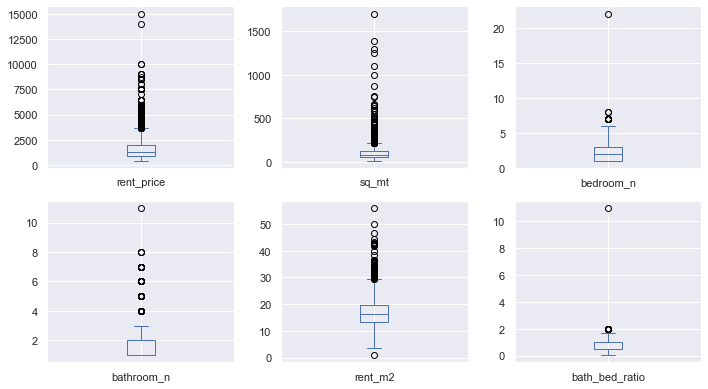

In [23]:
# outliers?
df_num.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8), color="b")
plt.tight_layout()
# plt.savefig("boxplots", dpi=400)
plt.show()

In [24]:
# lets remove all rents above 6000 eur and see the result
filt4 = (df["rent_price"] > 10000)
filt5 = (df["rent_price"] == df["sq_mt"])
filt6 = (df["bedroom_n"] > 10)
filt7 = (df["bathroom_n"] > 8)
filt8 = (df["bath_bed_ratio"] >= 2)

In [25]:
df.loc[filt4] = np.nan
df.loc[filt5] = np.nan
df.loc[filt6] = np.nan
df.loc[filt7] = np.nan
# df.loc[filt8]

In [26]:
df.dropna(how="any", inplace=True)

In [27]:
df = df.reset_index().drop("index", axis=1)

In [28]:
# Principal Component Analysis (PCA) identifies the combination of components 
# (directions in the feature space) that account for the most variance in the data.
from sklearn.decomposition import PCA
n_comp=3
X_df = df_num.drop(['rent_price'], axis=1)
X = X_df.values
pca = PCA(n_components=n_comp, svd_solver='full', random_state=0)
X_pca = pca.fit_transform(X)
for i in range(n_comp):
    print(X_df.columns[i])
    print(pca.explained_variance_ratio_[i])

sq_mt
0.9971403302784758
bedroom_n
0.0027123107541577557
bathroom_n
0.00010030452199780356


In [29]:
# Our data is positively skewed, which can impact negatively the predict powers of our model
print("Skewness")
for i in df_num.columns:
    print("{}:".format(i), df[i].skew()) 

Skewness
rent_price: 2.586795486211251
sq_mt: 4.898189397873106
bedroom_n: 1.0072698044569568
bathroom_n: 2.1214584229025655
rent_m2: 1.295562346624595
bath_bed_ratio: 0.7520021354948296


In [30]:
# we can try lof transformation, sqrt and boxcox
from scipy import stats
from scipy.special import boxcox, inv_boxcox

print("Skewness")

for i in df_num.columns:
    print("{} log transformed:".format(i), np.log(df[i]).skew())
    
print("====================================================")

for i in df_num.columns:
    print("{} sqrt transformed:".format(i), np.sqrt(df[i]).skew())
    
print("====================================================")

for i in df_num.columns:
    print("{} boxcox transformed:".format(i), boxcox(df[i],0).skew())

Skewness
rent_price log transformed: 0.7514161907726282
sq_mt log transformed: 0.6923053867822518
bedroom_n log transformed: -0.053191662600396025
bathroom_n log transformed: 0.8827619548215777
rent_m2 log transformed: -0.007468342135522828
bath_bed_ratio log transformed: -0.4119350948568657
rent_price sqrt transformed: 1.5030849982175927
sq_mt sqrt transformed: 2.0297679156358526
bedroom_n sqrt transformed: 0.408235959264808
bathroom_n sqrt transformed: 1.3732842858888121
rent_m2 sqrt transformed: 0.6106128283673073
bath_bed_ratio sqrt transformed: 0.08545423211186286
rent_price boxcox transformed: 0.7514161907726282
sq_mt boxcox transformed: 0.6923053867822518
bedroom_n boxcox transformed: -0.053191662600396025
bathroom_n boxcox transformed: 0.8827619548215777
rent_m2 boxcox transformed: -0.007468342135522828
bath_bed_ratio boxcox transformed: -0.4119350948568657


In [31]:
df_num_log = pd.DataFrame()
df_num_sqrt = pd.DataFrame()
df_num_boxcox = pd.DataFrame()

In [32]:
for i in df_num.columns:
    df_num_log[i] = np.log(df[i])
    
for i in df_num.columns:
    df_num_sqrt[i] = np.sqrt(df[i])
    
for i in df_num.columns:
    df_num_boxcox[i] = boxcox(df[i],0)

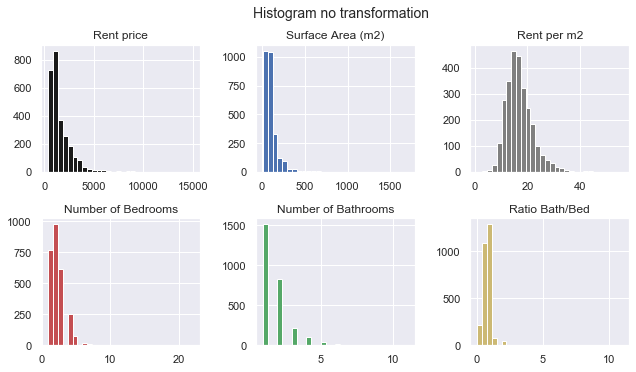

In [33]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")
fig.text(0.4, 1,"Histogram no transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_no_transformation.png", dpi=400)
plt.show()

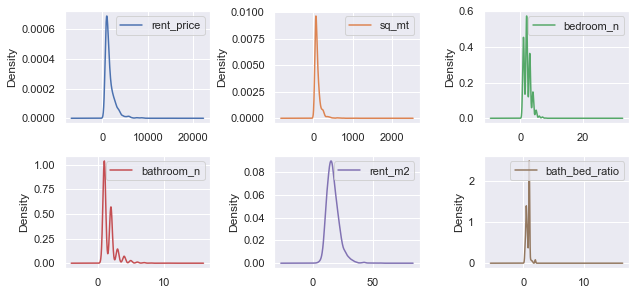

In [34]:
# Density plots are another way of getting a quick idea of the distribution of each attribute.
df_num.plot(kind='density', subplots=True, layout=(3,3), sharex=False,figsize=(9,6))
plt.tight_layout()
# plt.savefig("densityplot.png", dpi=400)
plt.show()

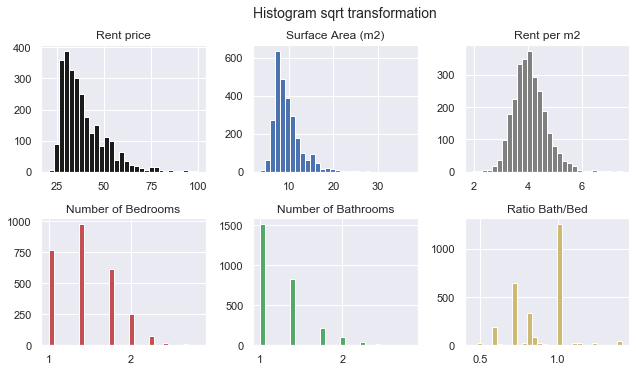

In [35]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num_sqrt["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num_sqrt["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num_sqrt["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num_sqrt["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num_sqrt["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num_sqrt["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")
fig.text(0.4, 1,"Histogram sqrt transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_sqrt_transformation.png", dpi=400)
plt.show()

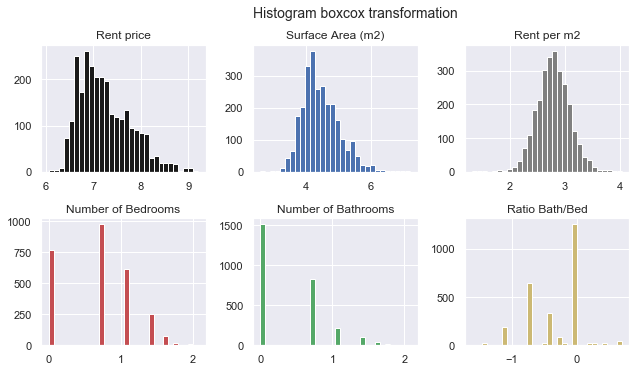

In [36]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num_boxcox["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num_boxcox["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num_boxcox["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num_boxcox["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num_boxcox["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num_boxcox["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")

fig.text(0.4, 1,"Histogram boxcox transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_boxcox.png", dpi=400)
plt.show()

In [37]:
 # we can also use df.transform()
# df_log = df.transform(func=["log"])

In [38]:
# Hence the best option is to boxcot transform our data

In [39]:
df_num_boxcox[["specific_location", "area_madrid"]] = df[["specific_location", "area_madrid"]]

In [40]:
df_boxcox = df_num_boxcox

In [41]:
df_num_boxcox.isna().sum()

rent_price           0
sq_mt                0
bedroom_n            0
bathroom_n           0
rent_m2              0
bath_bed_ratio       0
specific_location    0
area_madrid          0
dtype: int64

In [42]:
# transformmed df
df_boxcox

,rent_price,sq_mt,bedroom_n,bathroom_n,rent_m2,bath_bed_ratio,specific_location,area_madrid
0,6.620073,4.248495,1.098612,0.000000,2.371578,-1.098612,San Andrés,Villaverde
1,6.684612,3.828641,0.000000,0.000000,2.855970,0.000000,Prosperidad,Chamartín
2,7.600902,4.812184,1.098612,0.693147,2.788718,-0.405465,Argüelles,Moncloa-Aravaca
3,7.377759,4.905275,1.098612,0.693147,2.472484,-0.405465,La Paz,Fuencarral-El Pardo
4,6.684612,4.007333,0.000000,0.000000,2.677279,0.000000,Delicias,Arganzuela
...,...,...,...,...,...,...,...,...
2715,7.003065,4.317488,0.000000,0.000000,2.685577,0.000000,Ríos Rosas,Chamberí
2716,7.003065,4.248495,0.693147,0.000000,2.754570,-0.693147,Ríos Rosas,Chamberí
2717,8.006368,5.451038,1.386294,1.098612,2.555329,-0.287682,Almagro,Chamberí
2718,7.090077,4.499810,0.693147,0.693147,2.590267,0.000000,Mirasierra-Arroyo del Fresno,Fuencarral-El Pardo


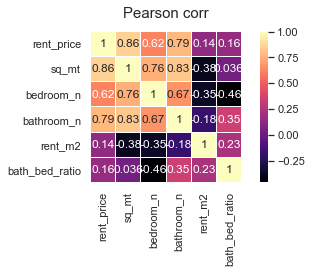

In [43]:
colormap=plt.cm.magma
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df_boxcox.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
# plt.savefig("corr.png", dpi=400)
plt.tight_layout()
plt.show()

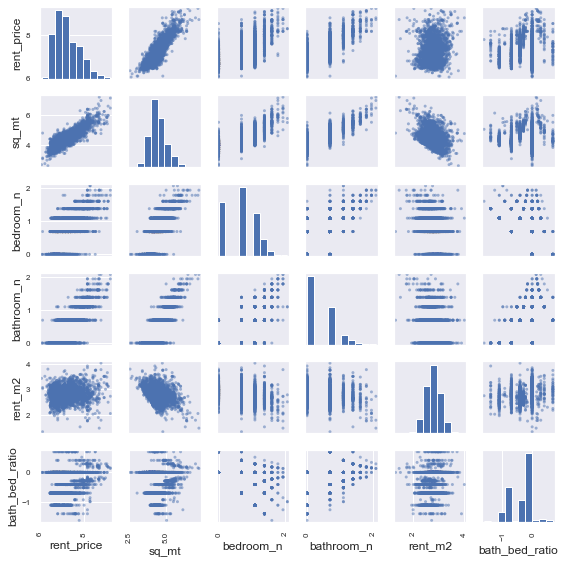

In [44]:
# Scatter plots are useful for spotting structured relationships between variables,
pd.plotting.scatter_matrix(df_boxcox, figsize=(8,8), color="b")
plt.tight_layout()
# plt.savefig("scatter_matrix.png", dpi=400)
plt.show()

In [45]:
pivot_price_area = pd.pivot_table(df, index=["area_madrid"], values=["rent_price"], aggfunc="mean").sort_values(by="area_madrid").reset_index()

In [46]:
pivot_area_sem =pd.pivot_table(df, index=["area_madrid"], values=["rent_price"], aggfunc="sem").sort_values(by="area_madrid").reset_index()

In [47]:
pivot_price_area["sem"] = pivot_area_sem["rent_price"]

In [48]:
pivot_price_area.sort_values(by="rent_price", ascending=False, inplace=True)

In [49]:
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [50]:
list_colors = list(cnames.values())

In [51]:
#generating a random  list of colors
random_color_list = list(pd.Series(list_colors).sample(21))

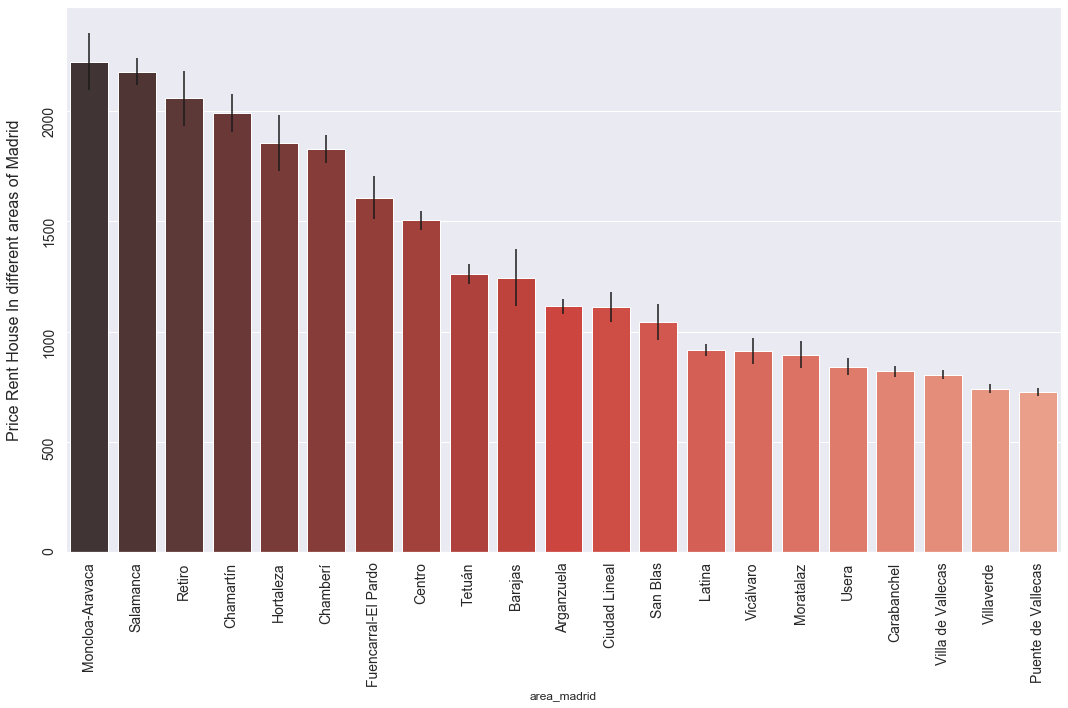

In [52]:
plt.rcParams["figure.figsize"] = (15,10)
sns.barplot(x=pivot_price_area["area_madrid"],y=pivot_price_area["rent_price"], data=pivot_price_area, yerr=pivot_price_area["sem"], palette="Reds_d")
plt.ylabel("Price Rent House In different areas of Madrid", fontsize=16, labelpad=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=90, fontsize=14)
plt.tight_layout()
# plt.savefig("area_rent_price.png", dpi=400)
plt.show()

In [53]:
pivot_count_loc = pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="count").\
sort_values(by="specific_location").reset_index()

In [54]:
pivot_count_loc.loc[pivot_count_loc["rent_price"]==1] = np.nan

In [55]:
pivot_count_loc.rename({"rent_price":"count"}, axis=1, inplace=True)

In [56]:
pivot_price_loc = pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="mean").\
sort_values(by="specific_location").reset_index()

In [57]:
pivot_price_loc["count"] = pivot_count_loc["count"]

In [58]:
pivot_price_loc.dropna(how="any", inplace=True)

In [59]:
pivot_price_loc.reset_index().drop("index", axis=1, inplace=True)

In [60]:
pivot_price_loc.shape

(124, 3)

In [61]:
pivot_loc_sem =pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="sem").\
sort_values(by="specific_location").reset_index()

In [62]:
pivot_loc_sem.rename({"rent_price":"sem"}, axis=1, inplace=True)

In [63]:
sem = (list(pivot_loc_sem["sem"])) # !

In [64]:
pivot_price_loc.dropna(how="any", inplace=True)

In [65]:
pivot_price_loc.reset_index().drop("index", axis=1, inplace=True)

In [66]:
pivot_price_loc.reset_index()

,index,specific_location,rent_price,count
0,0,Abrantes,850.000000,6.0
1,1,Acacias,1152.600000,25.0
2,2,Adelfas,1763.863636,22.0
3,3,Aeropuerto,2425.000000,5.0
4,4,Alameda de Osuna,1628.571429,7.0
...,...,...,...,...
119,126,Ventas,838.235294,17.0
120,127,Vinateros,725.000000,2.0
121,128,Virgen del Cortijo-Manoteras,1260.000000,6.0
122,129,Vista Alegre,787.916667,12.0


In [67]:
pivot_price_loc["sem"] = sem

In [68]:
# pivot_loc_sem.rename({"specific_location":"loc"}, axis=1, inplace=True)

In [69]:
pivot_price_loc.sort_values("rent_price", ascending=False, inplace=True)

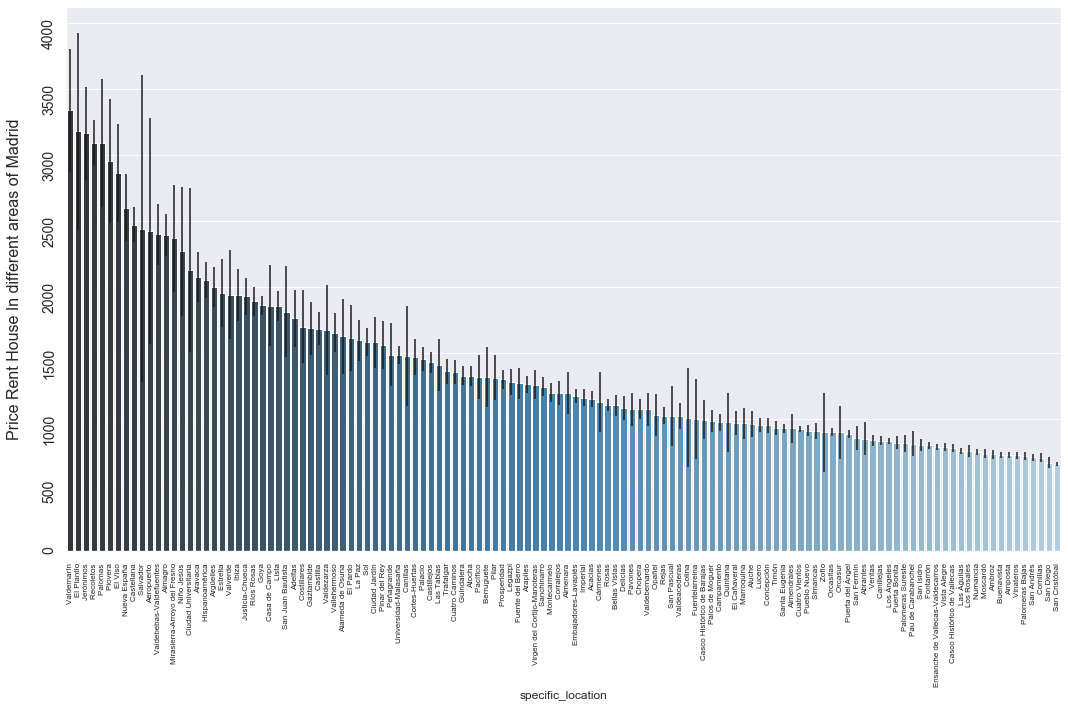

In [70]:
plt.rcParams["figure.figsize"] = (15,10)
sns.barplot(x=pivot_price_loc["specific_location"],y=pivot_price_loc["rent_price"], data=pivot_price_loc, yerr=pivot_price_loc["sem"],  palette="Blues_d")
plt.ylabel("Price Rent House In different areas of Madrid", fontsize=16, labelpad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=14)
plt.tight_layout()
# plt.savefig("location_rent_price.png", dpi=400)
plt.show()

# 3. Data Preprocessing

In [71]:
# 2. get dummy data
area = pd.get_dummies(df_boxcox['area_madrid'])

In [72]:
df_model = pd.concat([df_boxcox[["sq_mt","bedroom_n","bathroom_n"]], area], axis=1)

In [73]:
# 3 separate data into input and output variables for the model
X = (df_model) # Preprocessing all numeric variables, not categorical ones
y = df_boxcox["rent_price"]

In [74]:
# 4.1) 
    # Re-scaling data: When your data is comprised of attributes with varying scales, 
    # many machine learning algorithmscan benefit from rescaling the attributes to all have the same scale.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X) # use MinMaxScaler to revert the re-scaled data

In [75]:
rescaledX # # It did not bring any positive effect in our workcase

array([[0.36050626, 0.52832083, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.27060082, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48121189, 0.52832083, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.61801297, 0.66666667, 0.52832083, ..., 0.        , 0.        ,
        0.        ],
       [0.4143215 , 0.33333333, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.4705029 , 0.33333333, 0.33333333, ..., 0.        , 0.        ,
        0.        ]])

In [76]:
# 4.2) 
    # Standarized data: It is most suitable for techniques that assume a Gaussian
    # distribution in the input variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
standarizedX = scaler.transform(X)

In [77]:
standarizedX # It did not bring any positive effect in our workcase

array([[-3.59782775e-01,  7.99803693e-01, -8.11148268e-01, ...,
        -5.76177767e-02, -9.82398924e-02,  1.01791642e+01],
       [-1.08378644e+00, -1.36520943e+00, -8.11148268e-01, ...,
        -5.76177767e-02, -9.82398924e-02, -9.82398924e-02],
       [ 6.12253058e-01,  7.99803693e-01,  6.27868754e-01, ...,
        -5.76177767e-02, -9.82398924e-02, -9.82398924e-02],
       ...,
       [ 1.71390477e+00,  1.36673296e+00,  1.46963975e+00, ...,
        -5.76177767e-02, -9.82398924e-02, -9.82398924e-02],
       [ 7.35884289e-02,  7.61767239e-04,  6.27868754e-01, ...,
        -5.76177767e-02, -9.82398924e-02, -9.82398924e-02],
       [ 5.26014173e-01,  7.61767239e-04,  6.27868754e-01, ...,
        -5.76177767e-02, -9.82398924e-02, -9.82398924e-02]])

In [78]:
# 4.3) Normalize data: This pre-processing method
#      can be useful for sparse datasets (lots of zeros) with attributes of varying scales when using
#      algorithms that weight input values such as neural networks and algorithms that use distance
#      measures such as k-Nearest Neighbors.

from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
normalizedX = scaler.transform(X)

In [79]:
normalizedX # It did not bring any positive effect in our workcase

array([[0.94395482, 0.24409592, 0.        , ..., 0.        , 0.        ,
        0.22218568],
       [0.96754168, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.94658152, 0.21610271, 0.13634563, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.93701708, 0.23829982, 0.18884814, ..., 0.        , 0.        ,
        0.        ],
       [0.95483374, 0.14708185, 0.14708185, ..., 0.        , 0.        ,
        0.        ],
       [0.95938272, 0.13964073, 0.13964073, ..., 0.        , 0.        ,
        0.        ]])

# 4. Model selection and tuning

**Main Aspects to consider before building our model**
1) **Linearity**: assumes that the relationship between predictors and target variable is linear

2) **No noise**: eg. that there are no outliers in the data

3) **No collinearity**: if you have highly correlated predictors, it’s most likely your model will overfit

4) **Normal distribution**: more reliable predictions are made if the predictors and the target variable are normally distributed. Read [Here](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

5) **Scale**: it’s a distance-based algorithm, so preditors should be scaled — like with standard scaler

In [80]:
# train test split(train set, validation and a test set, )
    # train set is often used to test the ensemble models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) 

In [82]:
# 3. Exploring model performance and tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit # It will randomized the samples so that each fold will have equal distrubution
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR


# we can use a function to fing best model using GridSearchCV

def find_model(X,y):
    algos = {
        "linear_regression" : {"model":LinearRegression(), "params":{"normalize": [True,False]}},
        "lasso" : {"model":Lasso(), "params":{"alpha": [1,2], "selection":["random", "cyclic"]}},
        "decission_tree" : {"model":DecisionTreeRegressor(), "params":{"criterion": ["mse","friedman_mse"], "splitter":["best", "random"]}},
        "random_forest" : {"model":RandomForestRegressor(), "params":{"criterion": ["mse","mae"]}},
        "SVR": {"model": SVR(), "params":{"kernel": ["linear", "poly", "rbf"]}}
    }

    scores = []
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    for model, config in algos.items(): 
        gs = GridSearchCV(config["model"], config["params"], cv=cv, return_train_score=False)
        gs.fit(X,y)
        Best = gs.best_score_
        MAE = (cross_val_score(gs, X_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean()
        Params = gs.best_params_
        scores.append({"model": model,
                      "best_score" : Best,
                       "MAE": MAE,
                      "best_params": Params})
                      
    return pd.DataFrame(scores, columns=["model","best_score", "MAE", "best_params"])

df_performance_models = find_model(X,y)

In [83]:
# These values are quite low. Higher sample number or removal or ourliers could bring thie precicion higher

In [84]:
df_performance_models.sort_values(by="best_score", ascending=False)

,model,best_score,MAE,best_params
4,SVR,0.849461,-0.160449,{'kernel': 'rbf'}
0,linear_regression,0.843096,-0.164628,{'normalize': True}
3,random_forest,0.827955,-0.173776,{'criterion': 'mae'}
2,decission_tree,0.761562,-0.204736,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
1,lasso,-0.002989,-0.441051,"{'alpha': 1, 'selection': 'random'}"


In [85]:
# 5 test
from sklearn.svm import SVR
svr = SVR(kernel="rbf")
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

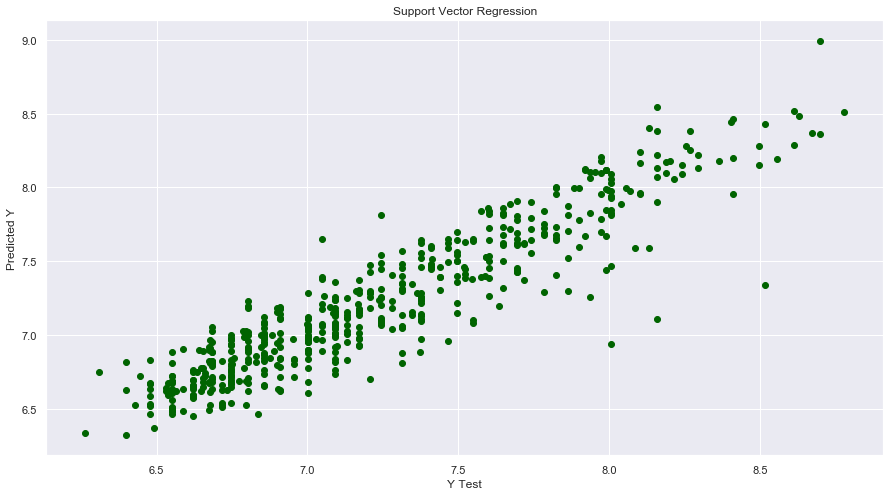

In [86]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred,c='darkgreen')
plt.title("Support Vector Regression")
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
# plt.savefig("SVR.png", dpi=400)
plt.show()

In [87]:
X

,sq_mt,bedroom_n,bathroom_n,Arganzuela,Barajas,Carabanchel,Centro,Chamartín,Chamberí,Ciudad Lineal,...,Moratalaz,Puente de Vallecas,Retiro,Salamanca,San Blas,Tetuán,Usera,Vicálvaro,Villa de Vallecas,Villaverde
0,4.248495,1.098612,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.828641,0.000000,0.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.812184,1.098612,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.905275,1.098612,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.007333,0.000000,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,4.317488,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2716,4.248495,0.693147,0.000000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2717,5.451038,1.386294,1.098612,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2718,4.499810,0.693147,0.693147,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
from scipy.special import boxcox, inv_boxcox

def predict_price(area, sq_mt, bedrooms, bathrooms):
    loc_index = np.where(X.columns==area)[0][0] # X is an np array so we use where method to loc the index
    
    x= np.zeros(len(X.columns))
    x[0] = boxcox(sq_mt,0)
    x[1] = boxcox(bedrooms,0)
    x[2] = boxcox(bathrooms,0)
    if loc_index >= 0:
        x[loc_index] = 1
    print(x)
        
    return inv_boxcox(svr.predict([x])[0],0)


In [89]:
predict_price('San Blas',260,4,4)

[5.56068163 1.38629436 1.38629436 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.        ]


2516.9309420259124

# 5. Productionazing the model

In [90]:
import pickle
with open ("Madrid_rent_price.pickle", "wb") as f:
    pickle.dump(svr,f)

In [91]:
import json
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))